# Ai4Youth - beHappy - Reddit extension with sentiment analysis
## Short info about project
This  `.ipynb`  file does contain code used to prepare data, format labels, create  `keras.Sequential`  train it accordingly create charts and finally save trained model by using  `model.save()`   and also tfidf tokenizer state via pickle for flask api's use

---

### Project directory structure:

Whole project directory acts as unpacked chrome extension.
In order to load it into supported browser (Google Chrome) you need to turn on developer mode ([Follow this procedure](https://support.google.com/chrome/a/answer/2714278?hl=en#:~:text=Go%20to%20chrome,or%20extension%20folder.))


Also in `{project folder}/python_api/` there is `main.py` file which is **required running** by extension in order to work.

---

## Startup procedure

  1. Load unpacked extension accordingly with instruction linked above
  2. Start `{project folder}/python_api/main.py` file, server will start at `0.0.0.0:5000`
  3. Open [reddit.com](https://www.reddit.com/r/popular/?geo_filter=GB) and visit thread in English

##Import libraries and download data
Import libraries necessary to process dataset train AI model
In addition nltk punkt and stopwords modules are downloaded

In [1]:
import pandas as pd
import nltk
import numpy as np
import re
import pickle

import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import tensorflow.python.keras.backend as K 
sess = K.get_session()
from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers, metrics

nltk.download('punkt')
nltk.download('stopwords')

## Data processing
Read dataset values to pandas dataframe and show genearal layout.

In [73]:
dataframe = pd.read_csv('FinalBalancedDataset.csv')
dataframe.head()

,Unnamed: 0,Toxicity,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation


Count number of post with labels:

- 0 - Neutral posts

- 1 - Toxic posts

In [74]:
dataframe['Toxicity'].value_counts()

0    32592
1    24153
Name: Toxicity, dtype: int64

In [107]:
print('There are', len(dataframe), 'posts')

There are 56745 posts


In [75]:
dataframe.columns

Index(['Unnamed: 0', 'Toxicity', 'tweet'], dtype='object')

Create view onto dataframe with only needed columns (it helps when dataset have many columns)

In [77]:
hatedf = dataframe[['Toxicity', 'tweet']]
len(hatedf)

56745

In [78]:
hatedf.head()

,Toxicity,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


Create PorterStemmmer instance and test it's behaviour

In [79]:
stemmer = PorterStemmer()

In [80]:
stemmer.stem('testing sentence')

'testing sent'

###Stemmization
Create function which deletes urls, special characters, numbers and english 'stopwords' (words that are common and doesn't give much information about subject)

Example is included below

In [81]:
def stemmize_sentence(text):
  ignore = stopwords.words('english')
  text = re.sub(r"(https:|http:|www\.)\S*", " ", text)
  text = re.sub(r"[^\w']", " ", text)
  text = re.sub(r"[\d]", " ", text)
  text = word_tokenize(text)
  text = [word.lower() for word in text]
  text = [word for word in text if word not in ignore]
  result = []
  for word in text:
    result.append(stemmer.stem(word))
  return " ".join(result)

In [83]:
stemmize_sentence('test 123 https://google.pl this string contains @#$%%')

'test string contain'

Create dataframe deep copy in order to save original data

In [84]:
hatedf_copy = hatedf.copy(deep=True)

####Stemmization example

In [85]:
stemmize_sentence(hatedf_copy['tweet'].tolist()[0])

'user father dysfunct selfish drag kid dysfunct run'

In [86]:
hatedf['tweet'].tolist()[0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [87]:
hatedf_copy['tweet'] = [stemmize_sentence(x) for x in hatedf_copy['tweet']]

Below comented lines were used to visualize most common words while working on stemmizer in order to highlight its flaws.

In [24]:
#occurence_count = Counter()

#for index, sentence in hatedf_copy.iterrows():
#  occurence_count.update(stemmize_sentence(sentence['tweet']).split())

In [26]:
#occurence_count.most_common(5000)

In [25]:
print(len(hatedf_copy))
hatedf_copy['Toxicity']

56745


0        0
1        0
2        0
3        0
4        0
        ..
56740    1
56741    1
56742    1
56743    1
56744    0
Name: Toxicity, Length: 56745, dtype: int64

### TFIDF
Create tfidf instance set `max_features_count` ('number of words in dictionary) and `stop_words` to `'english'`.
Then Construct Panda's dataframe `rdisd_df` with column names reffering to words being described.

In [27]:
max_features_count = 3000

tfidf = TfidfVectorizer(max_features=max_features_count, stop_words='english')
vectors = tfidf.fit_transform(hatedf_copy['tweet'])
names = tfidf.get_feature_names()
tfidf_df = pd.DataFrame(vectors.todense().tolist(), columns=names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
tfidf_df

,_beautifulkeezi,_sqquad,aap,ab,abl,abo,absolut,abt,abus,accept,...,ºð,¼ã,¼ï,¼ð,½ï,½ð,¾ð,à¹,ï¼,ó¾
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
print(names)

['_beautifulkeezi', '_sqquad', 'aap', 'ab', 'abl', 'abo', 'absolut', 'abt', 'abus', 'accept', 'accid', 'accord', 'account', 'accus', 'ace', 'achiev', 'acn', 'act', 'actin', 'action', 'activ', 'actor', 'actress', 'actual', 'ad', 'adam', 'adapt', 'add', 'addict', 'address', 'admit', 'adopt', 'ador', 'adult', 'advanc', 'adventur', 'advic', 'af', 'affect', 'affirm', 'afford', 'afraid', 'africa', 'african', 'afternoon', 'age', 'agenda', 'ago', 'agre', 'ah', 'ahead', 'ai', 'aicl', 'aid', 'aim', 'aint', 'air', 'airpo', 'aist', 'aka', 'al', 'alabama', 'alarm', 'albino', 'album', 'alcohol', 'alex', 'ali', 'alien', 'aliv', 'allah', 'allahsoil', 'alli', 'allig', 'allow', 'alon', 'alot', 'alreadi', 'alright', 'altern', 'altright', 'altwaystoh', 'alway', 'amaz', 'amazon', 'amber', 'amen', 'america', 'american', 'amo', 'amp', 'amsterdam', 'amwrit', 'anal', 'analyt', 'anchor', 'android', 'andâ', 'angel', 'anger', 'angri', 'anim', 'ann', 'anniversari', 'announc', 'annoy', 'annual', 'anoth', 'answer', 

### Create trening data

In [30]:
X = tfidf_df
Y = hatedf_copy['Toxicity']
x_train, x_test, y_train, y_test = train_test_split(tfidf_df, hatedf_copy['Toxicity'], random_state=2022, test_size=0.25, shuffle=True)

In [88]:
print('Train data count', len(x_train))
print('Test data count', len(x_test))

Train data count 42558
Test data count 14187


##Create Keras Sequential Model
We had performed multiple experiments in shape, N of layers and Dropout values. Model below represents final state of model which provided the best results in given architecture. There are a lot of architectures available for sentiment analysis problem we were looking for LSTM one ([Dimensional Sentiment Analysis Using a Regional CNN-LSTM Model](https://aclanthology.org/P16-2037.pdf)) which we haven't implemented because of lack of time, it could've yield better results. We tested GloVe approach but unfortunately we hadn't created any working model.

In [50]:
model = keras.Sequential()
model.add(layers.Dense(32,input_shape=(max_features_count,), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 32)                96032     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 96,065
Trainable params: 96,065
Non-trainable params: 0
_________________________________________________________________


For loss function we've choose binary_crossentropy as we are dealing with binary value, only 2 output class (neutral, toxic)

In [51]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [52]:
history = model.fit(X, Y, validation_split=0.3, batch_size=128, epochs=10, shuffle=True)

Epoch 1/10
311/311 [==============================] - 5s 13ms/step - loss: 0.3952 - accuracy: 0.8399 - val_loss: 0.4209 - val_accuracy: 0.8193
Epoch 2/10
311/311 [==============================] - 3s 8ms/step - loss: 0.1988 - accuracy: 0.9303 - val_loss: 0.2998 - val_accuracy: 0.8729
Epoch 3/10
311/311 [==============================] - 3s 8ms/step - loss: 0.1605 - accuracy: 0.9421 - val_loss: 0.2628 - val_accuracy: 0.8887
Epoch 4/10
311/311 [==============================] - 3s 8ms/step - loss: 0.1431 - accuracy: 0.9477 - val_loss: 0.2534 - val_accuracy: 0.8936
Epoch 5/10
311/311 [==============================] - 3s 8ms/step - loss: 0.1323 - accuracy: 0.9527 - val_loss: 0.2451 - val_accuracy: 0.8983
Epoch 6/10
311/311 [==============================] - 3s 8ms/step - loss: 0.1254 - accuracy: 0.9542 - val_loss: 0.2460 - val_accuracy: 0.8995
Epoch 7/10
311/311 [==============================] - 4s 12ms/step - loss: 0.1203 - accuracy: 0.9566 - val_loss: 0.2423 - val_accuracy: 0.9021
Epoc

Trained model charts which weren't affected by major overfitting and progressing learning it presented below.

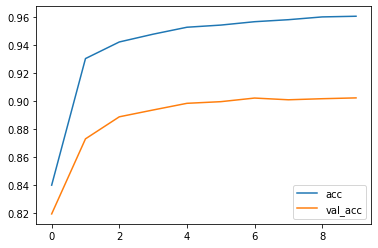

<Figure size 432x288 with 0 Axes>

In [53]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("acc_plot5.jpg")

Save tfidf state in order to use it later in flask backend

In [36]:
with open("tfidf-3.dat", "wb") as file:
  pickle.dump(tfidf, file, protocol=pickle.HIGHEST_PROTOCOL)

Simple function predicting category for given text

In [54]:
def predict_sentiment(text):
    
    tw = tfidf.transform([text]).toarray()
    prediction = model.predict(tw)
    print(prediction)
    #print("Predicted label: ", sentiment_label[1][prediction])


Example test performed on trained model

In [104]:
test_sentence1 = "Omg I love Matilda"

predict_sentiment("you are idiot")
predict_sentiment(test_sentence1)
predict_sentiment("Wife’s fault. I hate moving them just to get in bed when I’m tired")

1/1 [==============================] - 0s 37ms/step
[[0.13301058]]
1/1 [==============================] - 0s 33ms/step
[[0.01265477]]
1/1 [==============================] - 0s 41ms/step
[[0.04044882]]


Save finished model

In [56]:
model.save('Dense32-new-tfidf.h5')